Using device: cuda
Train size: 8549, Test size: 3665, Dim: 576
Running experiment over k values (GPU)...
k=0 | Test MSE=0.4280
k=20 | Test MSE=0.0865
k=0 | Test MSE=0.2433
k=20 | Test MSE=0.0802
k=0 | Test MSE=0.2774
k=20 | Test MSE=0.0709
k=0 | Test MSE=0.1216
k=20 | Test MSE=0.0701
k=0 | Test MSE=1.0048
k=20 | Test MSE=0.0846
k=0 | Test MSE=0.4393
k=20 | Test MSE=0.0864
k=0 | Test MSE=0.2579
k=20 | Test MSE=0.0799
k=0 | Test MSE=0.1581
k=20 | Test MSE=0.0746
k=0 | Test MSE=0.2564
k=20 | Test MSE=0.0600
k=0 | Test MSE=2.3210
k=20 | Test MSE=1.1927
k=0 | Test MSE=0.4184
k=20 | Test MSE=0.0863
k=0 | Test MSE=0.2248
k=20 | Test MSE=0.0805
k=0 | Test MSE=0.3357
k=20 | Test MSE=0.0716
k=0 | Test MSE=0.8796
k=20 | Test MSE=0.0653
k=0 | Test MSE=0.6243
k=20 | Test MSE=0.0915
k=0 | Test MSE=0.4433
k=20 | Test MSE=0.0863
k=0 | Test MSE=0.2667
k=20 | Test MSE=0.0805
k=0 | Test MSE=0.3155
k=20 | Test MSE=0.0818
k=0 | Test MSE=0.3362
k=20 | Test MSE=0.0757
k=0 | Test MSE=3.5181
k=20 | Test MSE=0.

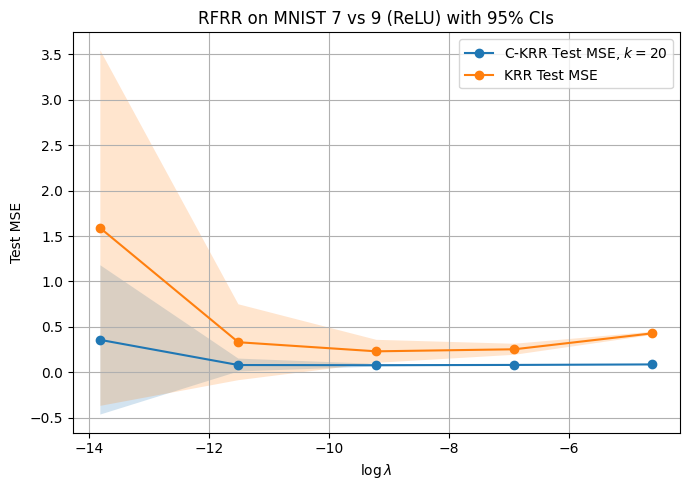

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch

# ============================================================
# 0. Device
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# 1. Load MNIST 7 vs 9 (CPU, numpy) and preprocess
# ============================================================
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

X_list, y_list = [], []

for img, label in mnist_train:
    if label in [7, 9]:
        # img: tensor (1,28,28)
        arr = img.numpy().squeeze()       # (28,28)
        arr = arr[2:-2, 2:-2]             # crop to (24,24)
        arr = arr.astype(np.float32)
        X_list.append(arr.flatten())      # length 24*24 = 576
        y_list.append(+1 if label == 7 else -1)

X = np.array(X_list, dtype=np.float32)    # shape (N, 576)
y = np.array(y_list, dtype=np.float32)    # shape (N,)

# train / test / valid split (still on CPU / numpy)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_full)
X_train = scaler.transform(X_train_full)
X_test = scaler.transform(X_test_full)

N_train, d = X_train.shape
N_test = X_test.shape[0]
print(f"Train size: {N_train}, Test size: {N_test}, Dim: {d}")

# ============================================================
# 2. Move data to GPU (torch tensors)
# ============================================================
X_train_t = torch.from_numpy(X_train).to(device)
X_test_t  = torch.from_numpy(X_test ).to(device)

y_train_t = torch.from_numpy(y_train).to(device)
y_test_t  = torch.from_numpy(y_test ).to(device)

# Ensure float32
X_train_t = X_train_t.float()
X_test_t  = X_test_t.float()

y_train_t = y_train_t.float()
y_test_t  = y_test_t.float()

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TwoLayerNet(nn.Module):
    def __init__(self, d, k):
        super().__init__()
        self.fc1 = nn.Linear(d, k)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(k, 1)

    def forward(self, x):
        h = self.act(self.fc1(x))
        out = self.fc2(h)
        return out, h

def create_unpenalized_features(
        X_train_t, y_train_t,
        d, k,
        epochs=5,
        batch_size=256,
        lr=1e-3,
        device="cuda"
    ):
    model = TwoLayerNet(d, k).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

    loss_fn = nn.MSELoss()

    N = X_train_t.shape[0]

    for epoch in range(epochs):
        perm = torch.randperm(N)
        for i in range(0, N, batch_size):
            idx = perm[i:i+batch_size]

            x_batch = X_train_t[idx]
            y_batch = y_train_t[idx].view(-1, 1)    # shape (B, 1)

            optimizer.zero_grad()
            pred, _ = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
    W1 = model.fc1.weight.data.clone()   # (k, d)
    b1 = model.fc1.bias.data.clone()     # (k,)
    W2 = model.fc2.weight.data.clone()   # (1, k)
    b2 = model.fc2.bias.data.clone()     # (1,)
    return W1, b1, W2, b2

def unpenalized_forward(X_t, W1, b1):
    return torch.relu(X_t @ W1.T + b1)

def mse_trained_unpenalized_model(X_test_t, y_test_t, W1, b1, W2, b2, device="cuda"):
    """
    Computes MSE of the trained 2-layer NN:
        y_hat = W2 * ReLU(X W1 + b1) + b2
    on a test set (X_test_t, y_test_t).
    """

    X = X_test_t.to(device)
    y = y_test_t.to(device).view(-1, 1)   # (N,1)

    # First layer
    h = torch.relu(X @ W1.T + b1)         # (N, k)

    # Second layer
    y_pred = h @ W2.T + b2                # (N,1)

    # Mean squared error
    mse = torch.mean((y_pred - y)**2)

    return mse.item()

# ============================================================
# 3. Random Feature Ridge Regression on GPU
# ============================================================
def build_random_features_gpu(X, omega, b):
    x = X @ omega.T + b.unsqueeze(0)
    return torch.relu(x)

def run_rfrr_gpu(X_train, y_train, X_test, y_test, W1, b1, k, m=10000, sigma=1.0, lam=0.1):
    """
    GPU version of RFRR with k unpenalized and m penalized features.
    X_train, X_test: tensors (N,d), (N_test,d) on device
    y_train, y_test: tensors (N,), (N_test,) on device
    """
    N, d = X_train.shape

    # random omegas and biases on GPU
    omega = torch.randn(k + m, d, device=device) * (1.0 / sigma)
    b = (2.0 * torch.rand(k + m, device=device) - 1.0)

    # indices
    idx_phi = torch.arange(0, k, device=device)
    idx_psi = torch.arange(k, k + m, device=device)
    
    # build features (Phi and Psi)
    if k > 0:
        Phi_train = unpenalized_forward(X_train, W1[:k], b1[:k])
        Phi_test  = unpenalized_forward(X_test,  W1[:k], b1[:k])
    else:
        Phi_train = torch.zeros((N, 0), device=device)
        Phi_test  = torch.zeros((X_test.shape[0], 0), device=device)

    Psi_train = build_random_features_gpu(X_train, omega[idx_psi], b[idx_psi]) / np.sqrt(m)
    Psi_test  = build_random_features_gpu(X_test,  omega[idx_psi], b[idx_psi]) / np.sqrt(m)

    A_train = torch.cat([Phi_train, Psi_train], dim=1)  # (N, k+m)
    A_test  = torch.cat([Phi_test,  Psi_test ], dim=1)  # (N_test, k+m)

    # Ridge regression with selective penalty (all on GPU)
    penalty = torch.cat([
        torch.zeros(k, device=device),
        lam * torch.ones(m, device=device)
    ])

    H = (A_train.T @ A_train) / N                 # (k+m, k+m)
    b_vec = (A_train.T @ y_train) / N            # (k+m,)

    M = H + torch.diag(penalty)                # SPD matrix
    M = M + 1e-10 * torch.eye(M.shape[0], device=M.device)

    # Solve M W = b_vec
    W = torch.linalg.solve(M, b_vec)             # (k+m,)

    # predictions
    y_pred_train = A_train @ W      # (N,)
    y_pred_test  = A_test  @ W      # (N_test,)

    mse_train = torch.mean((y_pred_train - y_train)**2).item()
    mse_test  = torch.mean((y_pred_test  - y_test )**2).item()

    return mse_train, mse_test

# ============================================================
# 4. Tune lambda at k=0 (on GPU)
# ============================================================
m = 10000
sigma = np.sqrt(d)

# ============================================================
# 5. Main experiment: vary k and compute CIs (GPU)
# ============================================================
R = 10
lambda_candidates = [
 1e-2, 1e-3, 1e-4, 1e-5, 1e-6
]
mses_test20 = []
mses_test2 = []


#print(f"Baseline Test MSE mean={errors.mean():.4f} ± {errors.std():.4f}")


W1, b1, W2, b2 = create_unpenalized_features(
    X_train_t, y_train_t,
    d=d, k=20,
    epochs=20,
    lr=1e-3,
    device=device
)

print("Running experiment over k values (GPU)...")
for r in range(R):
    mses_test0  = []
    mses_test  = []
    for lam in lambda_candidates:
        mse_train0, mse_test0 = run_rfrr_gpu(
            X_train_t, y_train_t,
            X_test_t,  y_test_t,
            W1, b1, 
            k=0, m=m, sigma=sigma, lam=lam
        )
        mses_test0.append(mse_test0)
        print(f"k=0 | Test MSE={mse_test0:.4f}")
        mse_train, mse_test = run_rfrr_gpu(
            X_train_t, y_train_t,
            X_test_t,  y_test_t,
            W1, b1, 
            k=20, m=m, sigma=sigma, lam=lam
        )
        mses_test.append(mse_test)
        print(f"k=20 | Test MSE={mse_test:.4f}")

    mses_test20.append(mses_test0)
    mses_test2.append(mses_test)

    


mses_test20  = np.array(mses_test20)
mses_test2  = np.array(mses_test2)
test_means = np.mean(mses_test2, axis = 0)
test_stds = np.std(mses_test2, axis = 0)
test_means0 = np.mean(mses_test20, axis = 0)
test_stds0 = np.std(mses_test20, axis = 0)

# ============================================================
# 6. Plot with 95% confidence intervals (CPU / matplotlib)
# ============================================================
ci = 1.96

test_upper0  = test_means0 + ci * test_stds0
test_lower0  = test_means0 - ci * test_stds0
test_upper  = test_means + ci * test_stds
test_lower  = test_means - ci * test_stds

plt.figure(figsize=(7,5))

# Test curve + CI
plt.plot(np.log(lambda_candidates), test_means, marker="o", label="C-KRR Test MSE, $k=$20")
plt.fill_between(np.log(lambda_candidates), test_lower, test_upper, alpha=0.2)

plt.plot(np.log(lambda_candidates), test_means0, marker="o", label="KRR Test MSE")
plt.fill_between(np.log(lambda_candidates), test_lower0, test_upper0, alpha=0.2)

plt.xlabel("$\\log\\lambda$")
plt.ylabel("Test MSE")
plt.title("RFRR on MNIST 7 vs 9 (ReLU) with 95% CIs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("mnist_relu_nn.png", dpi=600, bbox_inches="tight")
plt.show()